In [1]:
#Library import
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from gensim.corpora.dictionary import Dictionary

import spacy

from collections import Counter



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miguel.d.ferrusca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/miguel.d.ferrusca/Documents/ironhack/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
pd.options.display.max_rows = 100

In [3]:
# Loading datasets
df = pd.read_csv("data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
#df2 = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

## Data Exploration

In [4]:
df.head(2)

id             dateAdded           dateUpdated  \
0  AVpfhcniLJeJML43-t4G  2015-10-30T10:58:06Z  2019-04-22T10:21:26Z   
1  AWFFfd9KIwln0LfXiOe0  2018-01-30T04:58:34Z  2019-04-25T04:27:39Z   

                                                name  \
0  Expanding Accordion File Folder Plastic Portab...   
1      Fire TV Stick Streaming Media Player Pair Kit   

                              asins         brand  \
0  B0002LCUZK,B010CEC6MI,B01B25NN64  Amazonbasics   
1                        B00ZV9RDKK        Amazon   

                                          categories primaryCategories  \
0  Office,File Jackets & File Pockets,File Folder...   Office Supplies   
1  Electronics,TVs Entertainment,Featured Brands,...       Electronics   

                                           imageURLs  \
0  https://i.ebayimg.com/images/g/qAwAAOSwptJab16...   
1  https://static.bhphoto.com/images/smallimages/...   

                                                keys  ... reviews.numHelpful  \
0  expandingaccordionfilefolderplasticportabledoc...  ...                NaN   
1  0848719083781,firetvstickstreamingmediaplayerp...  ...                1.0   

  reviews.rating                                         sourceURLs  \
0              5  http://www.ebay.com/itm/Expanding-File-Tabs-Fo...   
1              5  https://www.bhphotovideo.com/c/product/1395909...   

                                  reviews.sourceURLs  \
0  https://www.ebay.com/itm/Expanding-Accordion-F...   
1  https://www.newegg.com/Product/Product.aspx?It...   

                                        reviews.text  \
0                             Exactly what I needed.   
1  Pros: Allows you to cut your cable. With many ...   

                                    reviews.title  reviews.username  \
0                                          Folder        99kurama99   
1  Quick, Simple, Easy to use and SAVE YOU MONEY!        Cameron G.   

   reviews.rating.1  Sentiment  Category  
0                 5   Positive  Accuracy  
1                 5   Positive     Value  

[2 rows x 27 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

In [6]:
df.shape

(28332, 27)

## Initial analysis

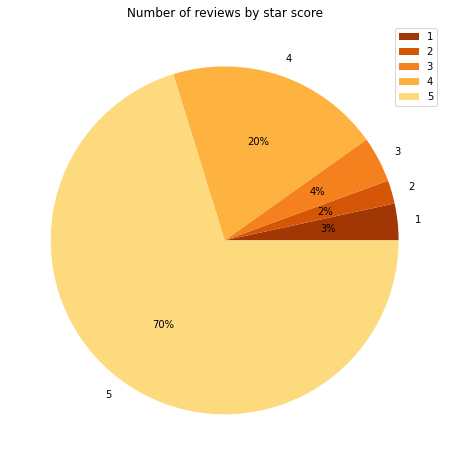

In [7]:
total_reviews = pd.DataFrame(df.groupby(df['reviews.rating.1'])['reviews.text'].agg('count'))

labels = total_reviews.index.to_list()
data = total_reviews['reviews.text']


plt.figure(figsize=(15,8))
colors = sns.color_palette('YlOrBr_r')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Number of reviews by star score")
plt.legend()
plt.show()

In [8]:
df.groupby(by=['primaryCategories','reviews.rating.1'])['reviews.text'].agg('count')

primaryCategories            reviews.rating.1
Animals & Pet Supplies       3                      1
                             4                      1
                             5                      4
Electronics                  1                    187
                             2                    183
                             3                    551
                             4                   3703
                             5                   9371
Electronics,Furniture        5                      2
Electronics,Media            1                      2
                             2                      2
                             3                      3
                             4                     42
                             5                    136
Health & Beauty              1                    751
                             2                    395
                             3                    534
                             4      

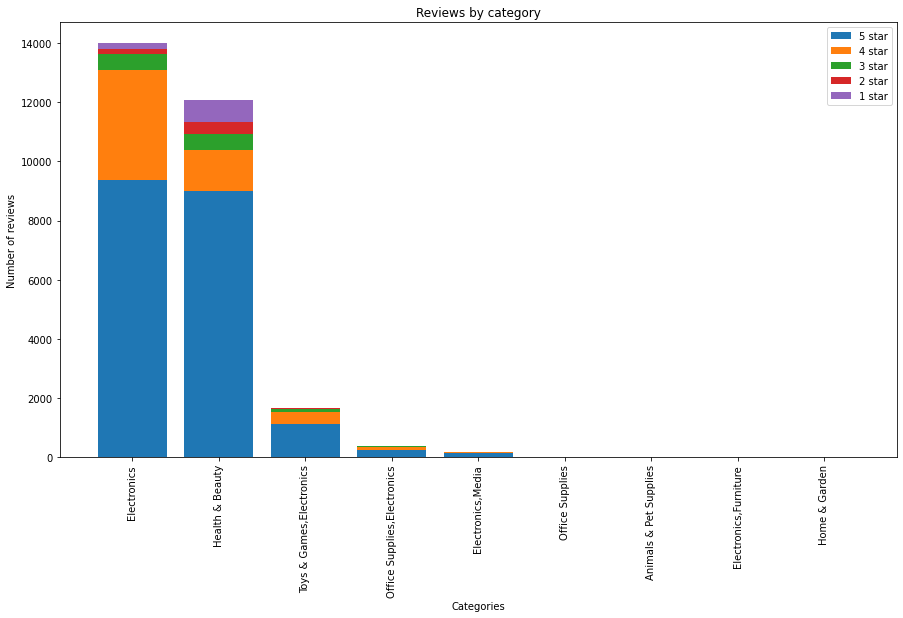

In [9]:
ratings_by_category = df.pivot_table(index= 'primaryCategories', 
                                           columns='reviews.rating.1', 
                                           values= 'reviews.text', 
                                           aggfunc='count').reset_index().fillna(0).sort_values(by=5, ascending=False)

one_star = ratings_by_category[1]
two_star = ratings_by_category[2]
three_star = ratings_by_category[3]
four_star = ratings_by_category[4]
five_star = ratings_by_category[5]
categories = ratings_by_category['primaryCategories']

plt.figure(figsize=(15,8))
plt.bar(categories, five_star, label= '5 star')
plt.bar(categories,four_star, bottom=five_star, label='4 star')
plt.bar(categories, three_star, bottom=(five_star+four_star), label='3 star')
plt.bar(categories, two_star, bottom=(five_star+four_star+three_star), label='2 star')
plt.bar(categories, one_star, bottom=(five_star+four_star+three_star+two_star), label='1 star')


plt.xlabel('Categories')
plt.ylabel('Number of reviews')
#plt.grid(b=None, which='major', axis='y')
plt.title("Reviews by category")
plt.legend()
plt.xticks(rotation=90)

plt.show()


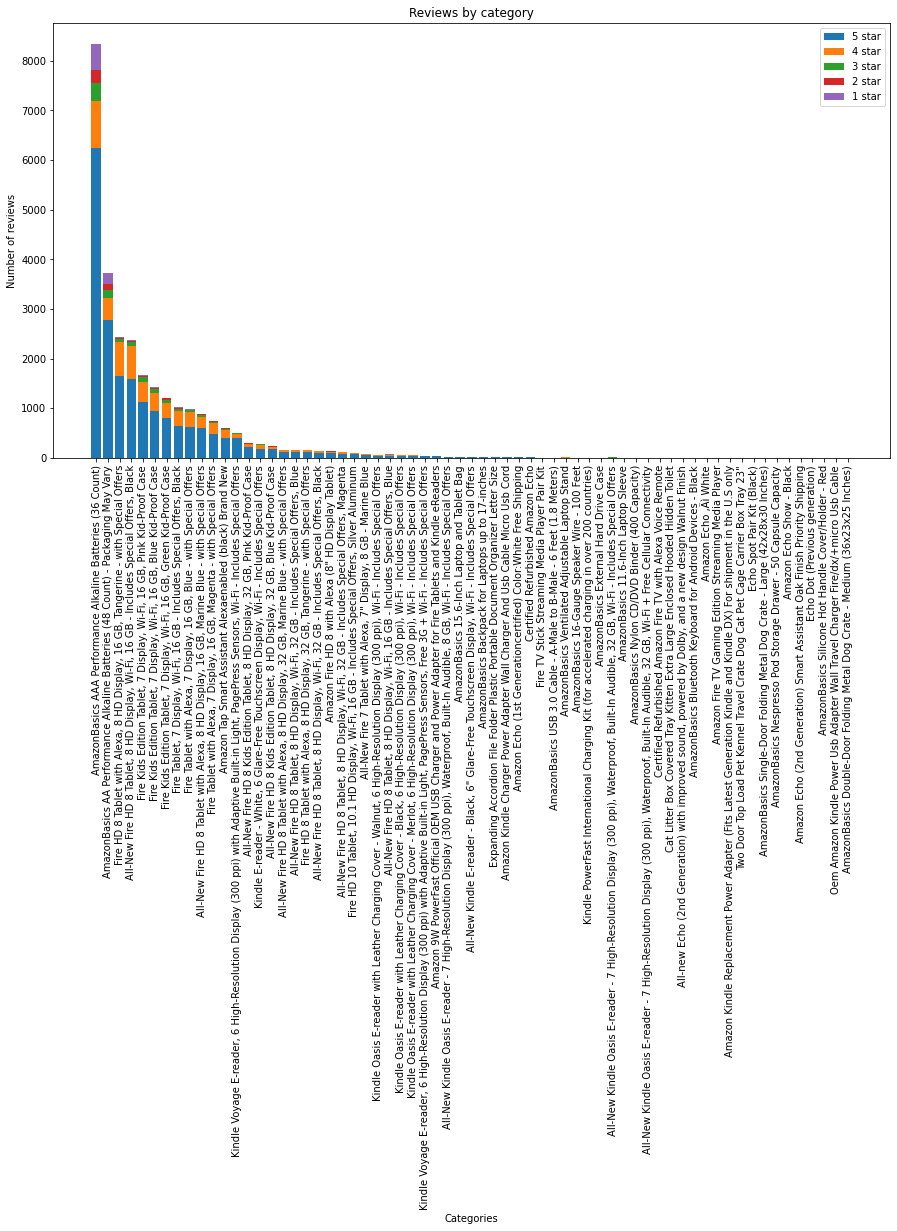

In [10]:
ratings_by_product = df.pivot_table(index= 'name', 
                                           columns='reviews.rating.1', 
                                           values= 'reviews.text', 
                                           aggfunc='count').reset_index().fillna(0).sort_values(by=5, ascending=False)

one_star = ratings_by_product[1]
two_star = ratings_by_product[2]
three_star = ratings_by_product[3]
four_star = ratings_by_product[4]
five_star = ratings_by_product[5]
categories = ratings_by_product['name']

plt.figure(figsize=(15,8))
plt.bar(categories, five_star, label= '5 star')
plt.bar(categories,four_star, bottom=five_star, label='4 star')
plt.bar(categories, three_star, bottom=(five_star+four_star), label='3 star')
plt.bar(categories, two_star, bottom=(five_star+four_star+three_star), label='2 star')
plt.bar(categories, one_star, bottom=(five_star+four_star+three_star+two_star), label='1 star')


plt.xlabel('Categories')
plt.ylabel('Number of reviews')
#plt.grid(b=None, which='major', axis='y')
plt.title("Reviews by category")
plt.legend()
plt.xticks(rotation=90)

plt.show()

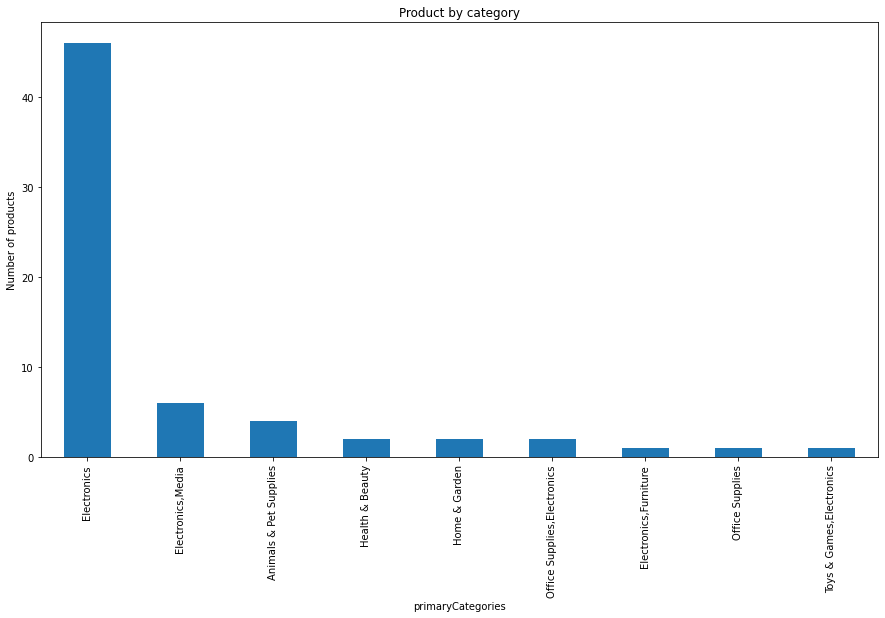

In [11]:
products_by_category = df.groupby(by=['primaryCategories'])['name'].agg('nunique').sort_values(ascending=False)

plt.figure(figsize=(15,8))

plt.xlabel('Category')
plt.ylabel('Number of products')
plt.grid(b=None, which='major', axis='y')
plt.title("Product by category")

products_by_category.plot(kind='bar')
plt.show()

# Data Cleaning and preparation

In [12]:
# Keep meaningful columns

clean_df = df[['asins', 'name', 'primaryCategories', 'reviews.rating.1', 'reviews.text']]

In [13]:
# Remove products with few reviews

reviews_by_product = df.groupby(df.name)['reviews.text'].agg('count').reset_index().sort_values(by='reviews.text', ascending=False)
high_reviewed_prods = reviews_by_product[reviews_by_product['reviews.text']>=50]['name'].unique().tolist()

clean_df = clean_df[clean_df['name'].isin(high_reviewed_prods)]

In [14]:
clean_df.name.unique()

array(['Amazon Tap Smart Assistant Alexaenabled (black) Brand New',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case',
       'Amazon Fire HD 8 with Alexa (8" HD Display Tablet)',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers',
       'All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case',
       'Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers',
       'All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers',
       'All-New Fire 7 Tablet with Alexa, 7" Display, 8 GB - Marine Blue',
       'Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black',
       'AmazonBasics AAA Performance Alkaline Batteries (36 Count)',
       'Fir

In [15]:
clean_df.shape

(28031, 5)

# Sentiment analysis with TextBlob

In [16]:
# Getting text polarity and subjectivity

clean_df['polarity'] = [TextBlob(review).sentiment.polarity for review in clean_df['reviews.text'].tolist()]
clean_df['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in clean_df['reviews.text'].tolist()]

<AxesSubplot:xlabel='reviews.rating.1', ylabel='polarity'>

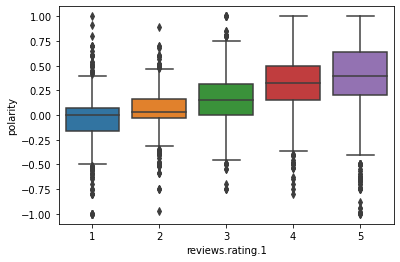

In [17]:
sns.boxplot(x=clean_df['reviews.rating.1'], y=clean_df['polarity'])

# Bag of words from reviews

In [18]:
product = 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)'

product_reviews = clean_df[clean_df.name == product]

In [19]:
vect = CountVectorizer(max_features=1000, ngram_range=(1, 2), max_df=500, stop_words=ENGLISH_STOP_WORDS)

vect.fit(product_reviews['reviews.text'])

X_review = vect.transform(product_reviews['reviews.text'])

X_df = pd.DataFrame(X_review.toarray(), columns=vect.get_feature_names())

# Building wordcloud

/Users/miguel.d.ferrusca/Documents/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='polarity'>

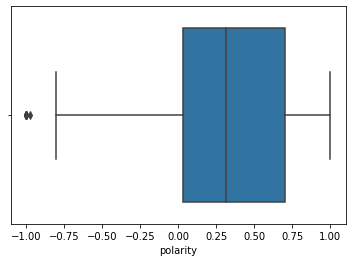

In [20]:
# understanding overall sentiment

sns.boxplot(product_reviews.polarity)

In [21]:
# get most common word of set of reviews

reviews = str([i for i in product_reviews['reviews.text']])
words= nltk.tokenize.word_tokenize(reviews)
reviews_words= [word for word in words if word.isalnum()]

counter = Counter(reviews_words)

top_words = [counter.most_common()[i][0] for i in range(0,20)]

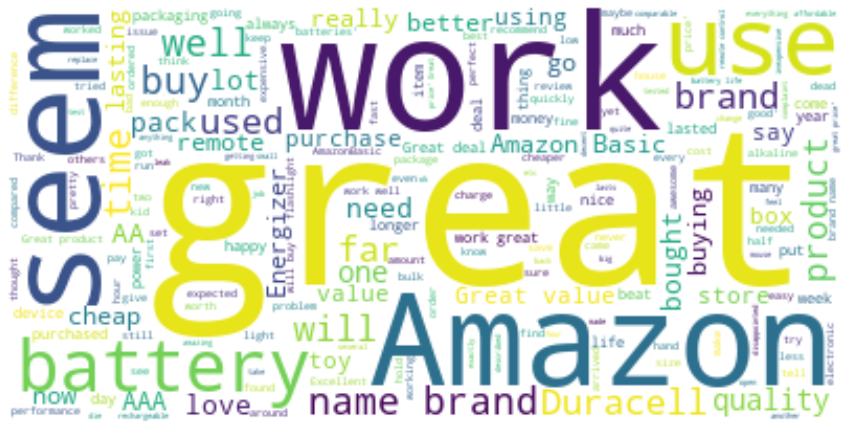

In [22]:
# updating stopwords with non meaningful words
my_stop_words = STOPWORDS.update(top_words)

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(reviews)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

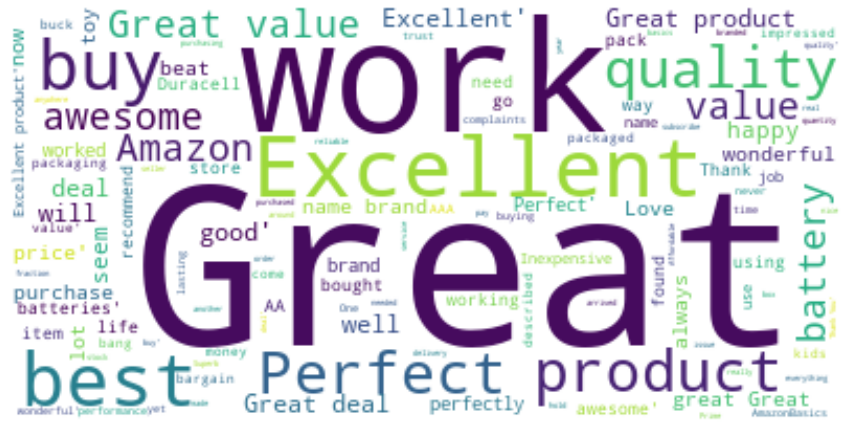

In [23]:
# positive reviews

positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))&
                                   (product_reviews['reviews.rating.1'].isin([4,5]))]

positive_reviews_string = str([i for i in positive_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

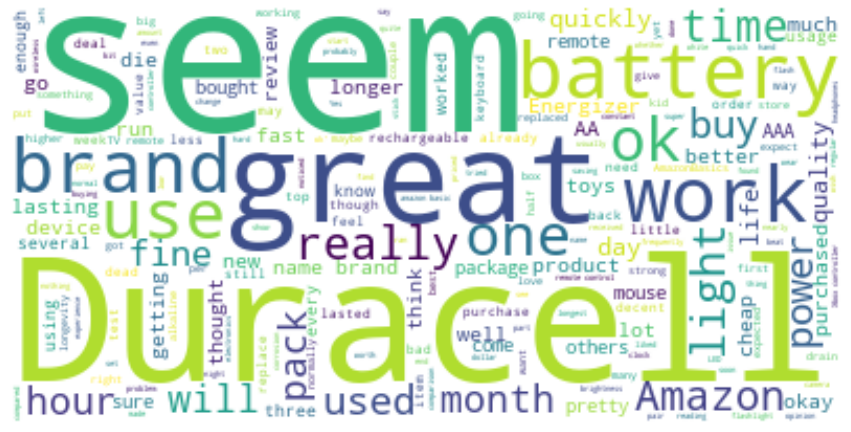

In [24]:
# neutral reviews

neutral_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.25))&
                                   (product_reviews['polarity']<product_reviews['polarity'].quantile(.75))&
                                   (product_reviews['reviews.rating.1'].isin([3]))]

neutral_reviews_string = str([i for i in neutral_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(neutral_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

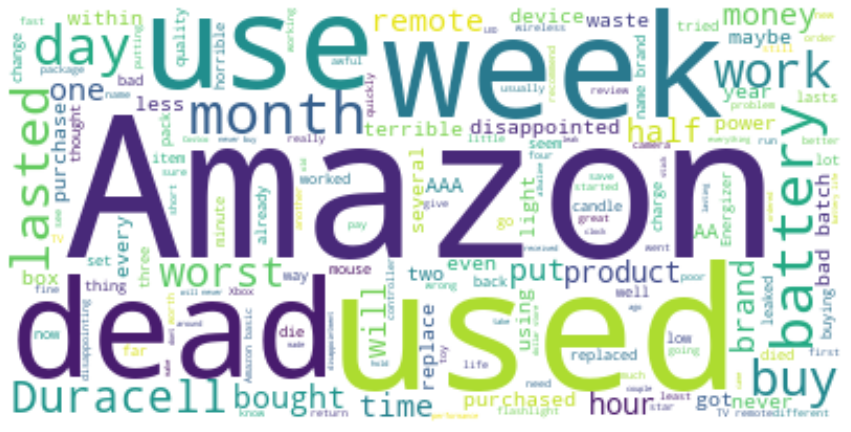

In [25]:
# negative reviews

negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))&
                                   (product_reviews['reviews.rating.1'].isin([1,2]))]


negative_reviews_string = str([i for i in negative_reviews['reviews.text']])

#Create wordcloud
cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [26]:
# wordcloud function

def plot_wordclouds(product):
    
    product_reviews = clean_df[clean_df.name == product]
    
    #plotting overall sentiment
    sns.boxplot(product_reviews.polarity)
    plt.figure(figsize=(15,8))
    plt.show()
    
    # updating stopwords for non meaningful words
    reviews = str([i for i in product_reviews['reviews.text']])
    words= nltk.tokenize.word_tokenize(reviews)
    reviews_words= [word for word in words if word.isalnum()]
    counter = Counter(reviews_words)
    top_words = [counter.most_common()[i][0] for i in range(0,20)]
    stopwords = STOPWORDS
    my_stop_words = stopwords.update(top_words)
    
    
    
    
    #plotting positive reviews cloud
    positive_reviews = product_reviews[(product_reviews['polarity']>product_reviews['polarity'].quantile(.9))&
                                   (product_reviews['reviews.rating.1'].isin([4,5]))]
    positive_reviews_string = str([i for i in positive_reviews['reviews.text']])
    
    #Create wordcloud
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(positive_reviews_string)
    
    # Plot wordclou
    print("Most common words on positive reviews")
    plt.figure(figsize=(15,8))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()
    
    
    
    #plotting negative reviews cloud
    negative_reviews = product_reviews[(product_reviews['polarity']<product_reviews['polarity'].quantile(.1))&
                                   (product_reviews['reviews.rating.1'].isin([1,2]))]
    
    negative_reviews_string = str([i for i in negative_reviews['reviews.text']])
    
    #Create wordcloud
    cloud = WordCloud(background_color='white', stopwords=my_stop_words).generate(negative_reviews_string)
    
    # Plot wordcloud
    print("Most common words on negative reviews")
    plt.figure(figsize=(15,8))
    plt.imshow(cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.show()
    
    

/Users/miguel.d.ferrusca/Documents/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


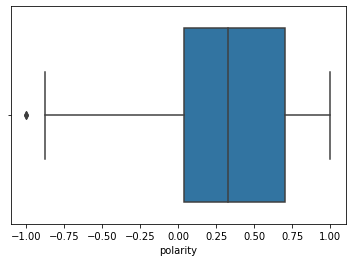

<Figure size 1080x576 with 0 Axes>

Most common words on positive reviews


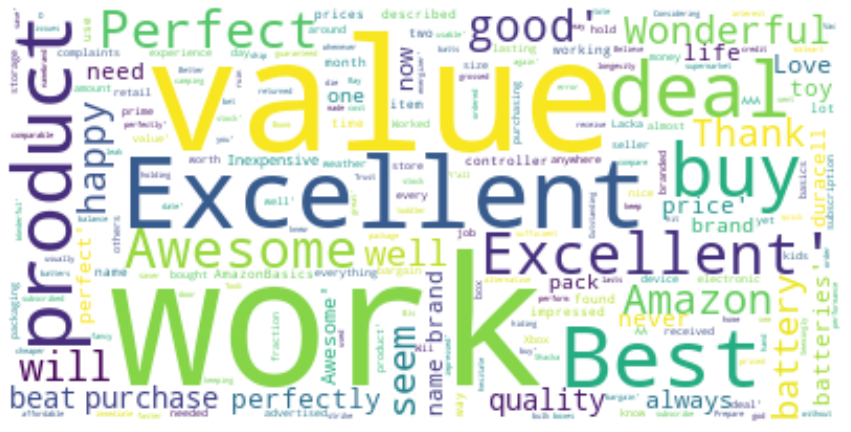

Most common words on negative reviews


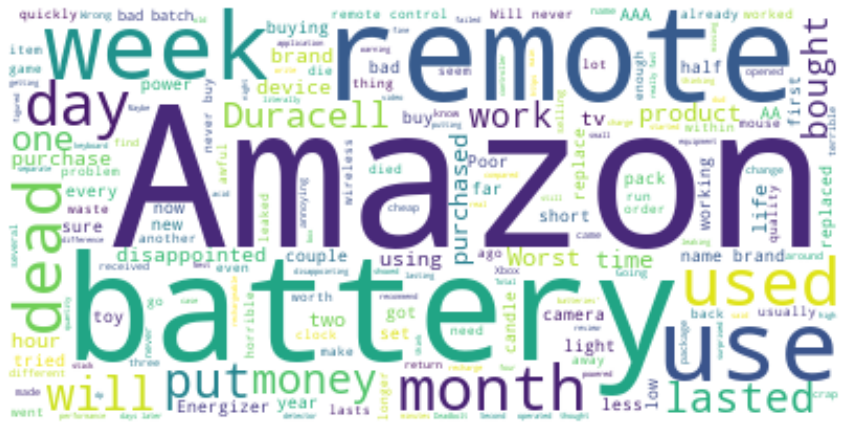

In [39]:
plot_wordclouds('AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary')

# Clutter

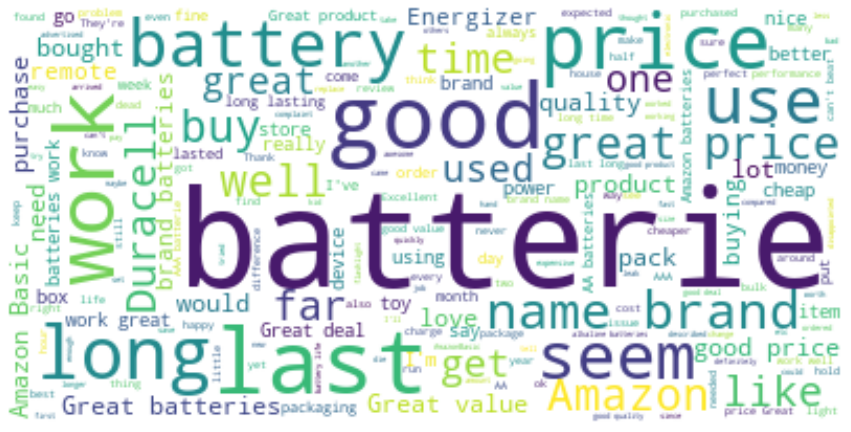

In [29]:
# Plotting wordcloud for product with the most reviews

#Getting reviews for top 1 product and creating a string of words
top_1_reviews = clean_df[clean_df['name']=='AmazonBasics AAA Performance Alkaline Batteries (36 Count)']['reviews.text'].tolist()
top_1_reviews_string = ' '.join(top_1_reviews)

#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

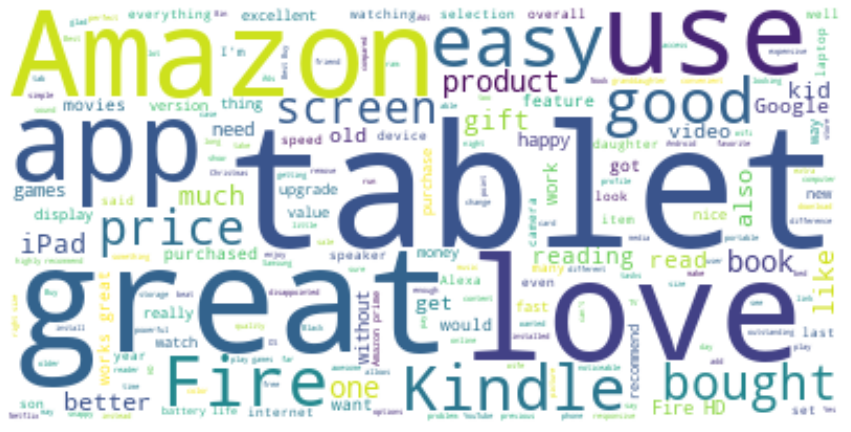

In [30]:
# Plotting wordcloud for product with the most reviews

#Getting reviews for top 1 product and creating a string of words
top_1_reviews = clean_df[clean_df['asins']=='B01J94SWWU']['reviews.text'].tolist()
top_1_reviews_string = ' '.join(top_1_reviews)

#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create wordcloud
top_1_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28031 entries, 7 to 28269
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   asins              28031 non-null  object 
 1   name               28031 non-null  object 
 2   primaryCategories  28031 non-null  object 
 3   reviews.rating.1   28031 non-null  int64  
 4   reviews.text       28031 non-null  object 
 5   polarity           28031 non-null  float64
 6   subjectivity       28031 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.7+ MB


In [32]:
reduced_df = clean_df[['asins', 'name', 'reviews.rating.1', 'reviews.text']]

In [33]:
# Getting text polarity and subjectivity

reduced_df['polarity'] = [TextBlob(review).sentiment.polarity for review in reduced_df['reviews.text'].tolist()]
reduced_df['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in reduced_df['reviews.text'].tolist()]

<ipython-input-33-4dda4cc068fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['polarity'] = [TextBlob(review).sentiment.polarity for review in reduced_df['reviews.text'].tolist()]
<ipython-input-33-4dda4cc068fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['subjectivity'] = [TextBlob(review).sentiment.subjectivity for review in reduced_df['reviews.text'].tolist()]


In [34]:
top_1_asin_positive_reviews = reduced_df[
    (reduced_df['asins']=='B018T075DC') & 
    (reduced_df['polarity'] > .33)]['reviews.text'].tolist()

top_1_asin_positive_reviews_string = ' '.join(top_1_asin_positive_reviews)


top_1_asin_negative_reviews = reduced_df[
    (reduced_df['asins']=='B018T075DC') & 
    (reduced_df['polarity'] < -.33)]['reviews.text'].tolist()

top_1_asin_negative_reviews_string = ' '.join(top_1_asin_negative_reviews)

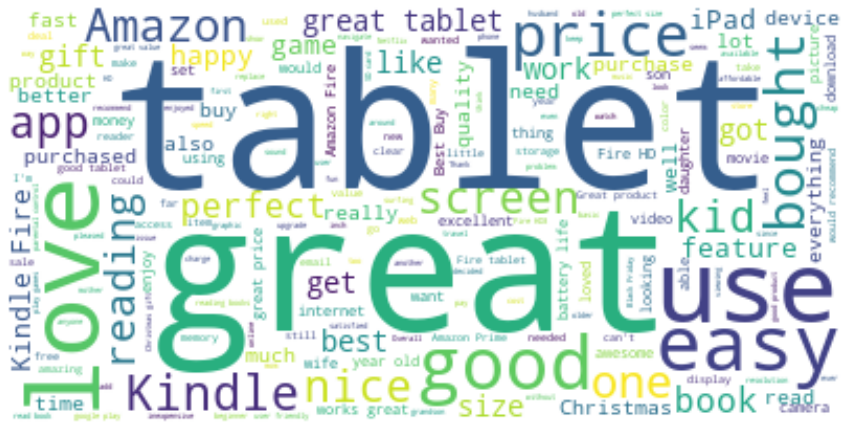

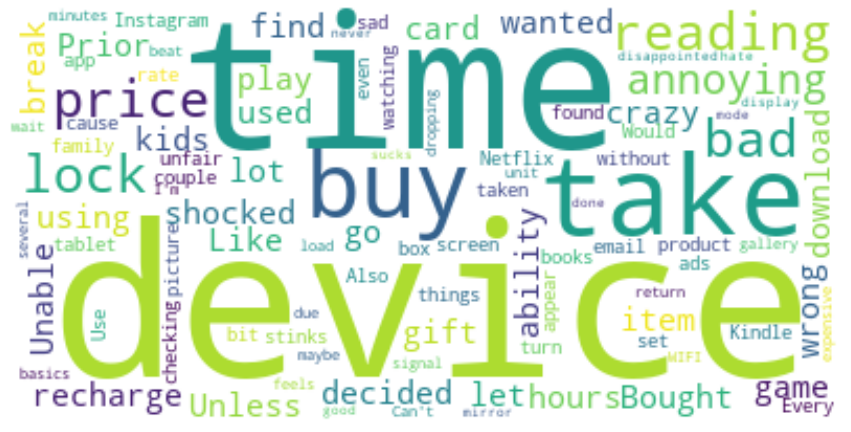

In [35]:
#load stop wwords
stopwords = nltk.corpus.stopwords.words('english')

#Create positive wordcloud
top_1_positive_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_asin_positive_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_positive_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()



#Create negative wordcloud
top_1_negative_wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(top_1_asin_negative_reviews_string)

# Plot wordcloud
plt.figure(figsize=(15,8))
plt.imshow(top_1_negative_wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()



In [36]:
reduced_df.groupby(reduced_df['asins'])['reviews.text'].agg('count').sort_values(ascending=False)

asins
B00QWO9P0O,B00LH3DMUO               8343
B00QWO9P0O,B01IB83NZG,B00MNV8E0C    3728
B018T075DC                          2443
B018SZT3BK,B01AHB9CN2               2370
B018Y226XO                          1676
B018Y22C2Y                          1425
B018Y23MNM                          1212
B018Y22BI4                          1024
B018Y225IA                           987
B01J94YIT6                           883
B018Y224PY                           745
B01BH83OOM                           601
B00IOY8XWQ                           505
B01J94SCAM                           293
B017JG41PC                           287
B01J94SBEY                           233
B01J94T1Z2                           160
B01AHB9C1E                           156
B01AHBDCKQ                           156
B01ACEKAJY                           140
B01J94SWWU                           130
B01AHB9CYG                           115
B0189XZRTI,B0189XYY0Q,B0189XZ0KY      99
B01IO618J8                            82
B01AHBBG04

In [37]:
clean_df[clean_df['name'] == 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)']

asins  \
1758   B00QWO9P0O,B00LH3DMUO   
1765   B00QWO9P0O,B00LH3DMUO   
1766   B00QWO9P0O,B00LH3DMUO   
1767   B00QWO9P0O,B00LH3DMUO   
1768   B00QWO9P0O,B00LH3DMUO   
...                      ...   
28151  B00QWO9P0O,B00LH3DMUO   
28152  B00QWO9P0O,B00LH3DMUO   
28153  B00QWO9P0O,B00LH3DMUO   
28155  B00QWO9P0O,B00LH3DMUO   
28156  B00QWO9P0O,B00LH3DMUO   

                                                    name primaryCategories  \
1758   AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
1765   AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
1766   AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
1767   AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
1768   AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
...                                                  ...               ...   
28151  AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
28152  AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
28153  AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
28155  AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   
28156  AmazonBasics AAA Performance Alkaline Batterie...   Health & Beauty   

       reviews.rating.1                                       reviews.text  \
1758                  1  First eight batteries I tried barely had a cha...   
1765                  5  High quality, long lasting, fast delivery. And...   
1766                  2        they dont last long at all not worth buying   
1767                  5                                           Amazing!   
1768                  5                      Cheap price and nice quality.   
...                 ...                                                ...   
28151                 5  Decent price for the grand kid's toys. Last a ...   
28152                 3  They do not last as long as other batteries. :...   
28153                 5  Nice price, seem to work great! Will post agai...   
28155                 5                                        great value   
28156                 3  Great price for these alkaline batteries. Bein...   

       polarity  subjectivity  
1758   0.156250      0.216667  
1765   0.262000      0.458000  
1766  -0.066667      0.188889  
1767   0.750000      0.900000  
1768   0.500000      0.850000  
...         ...           ...  
28151  0.341667      0.583333  
28152 -0.261923      0.522179  
28153  0.416667      0.783333  
28155  0.800000      0.750000  
28156  0.091667      0.290278  

[8343 rows x 7 columns]

<AxesSubplot:xlabel='reviews.rating.1', ylabel='polarity'>

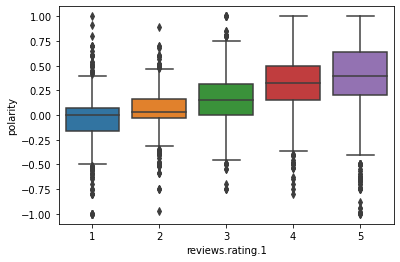

In [38]:
sns.boxplot(x=reduced_df['reviews.rating.1'], y=reduced_df['polarity'])